# 03 · Explanation & Insight Discovery

本 Notebook 负责第三阶段：**解释与洞察**，基于上一步得到的 *简化版 XGBoost* 模型，完成局部与全局解释、错误案例洞察并保存所有可视化。

## 3.0 准备：加载 Artifacts

In [1]:
import os, joblib, json, warnings
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import shap
from scipy.stats import spearmanr, kendalltau

warnings.filterwarnings("ignore", message="is_categorical is deprecated")
plt.rcParams["figure.figsize"] = (7.5, 5)

ARTIFACTS_DIR = os.path.join("Task3", "artifacts")
assert os.path.isdir(ARTIFACTS_DIR), f"Artifacts 目录不存在：{ARTIFACTS_DIR}"

def load_artifact(name: str):
    path = os.path.join(ARTIFACTS_DIR, f"{name}.joblib")
    if not os.path.isfile(path):
        raise FileNotFoundError(f"缺少工件：{path}，请先运行 02_Notebook 保存单元格")
    return joblib.load(path)

# 载入全部工件
xgb_simp_clf        = load_artifact('xgb_simp_clf')
scaler_simp         = load_artifact('scaler_simp')
X_test_simp         = load_artifact('X_test_simp')
y_test              = load_artifact('y_test')
xgb_simp_t_opt      = load_artifact('xgb_simp_t_opt')
xgb_simp_prob_test  = load_artifact('xgb_simp_prob_test')
simplified_features = load_artifact('simplified_features')

print("✅ Artifacts all loaded.")

✅ Artifacts all loaded.


## 3.1 SHAP 分析准备

In [2]:
explainer     = shap.TreeExplainer(xgb_simp_clf)
X_test_scaled = scaler_simp.transform(X_test_simp)
shap_values   = explainer.shap_values(X_test_scaled)

print(f"SHAP values shape: {shap_values.shape}")

SHAP values shape: (114, 20)


## 3.2 个体化解释与置信度分析

In [3]:
### 3.2.1 兼容所有情况的案例选取
y_pred = (xgb_simp_prob_test > xgb_simp_t_opt).astype(int)

def pick_example(mask, fallback='random'):
    idx = np.where(mask)[0]
    if len(idx):
        return int(idx[0])
    # 若缺少该类别，随机抽样一个备选样本
    return int(np.random.choice(np.arange(len(y_test)), 1)[0])

case_indices = {
    "True Positive (Malignant)": pick_example((y_test==1)&(y_pred==1)),
    "True Negative (Benign)"   : pick_example((y_test==0)&(y_pred==0)),
    "False Negative"           : pick_example((y_test==1)&(y_pred==0)),
    "False Positive"           : pick_example((y_test==0)&(y_pred==1)),
}
print("Chosen indices →\n", json.dumps(case_indices, indent=2))

Chosen indices →
 {
  "True Positive (Malignant)": 1,
  "True Negative (Benign)": 0,
  "False Negative": 16,
  "False Positive": 2
}


In [4]:
### 3.2.2 & 3.2.3 Force Plot + 改进版“解释置信度”
shap.initjs()

def confidence_score(push, pull, eps=1e-6):
    """(push - pull)/(push + pull) ∈ [-1,1]"""
    return (push - pull) / (push + pull + eps)

for name, idx in case_indices.items():
    display(shap.force_plot(explainer.expected_value, shap_values[idx], 
                            X_test_simp.iloc[idx], matplotlib=False))
    sv = shap_values[idx]
    push = sv[sv>0].sum(); pull = np.abs(sv[sv<0]).sum()
    conf = confidence_score(push, pull)
    print(f"{name} | push={push:.3f} pull={pull:.3f} conf={conf:.2f}")

True Positive (Malignant) | push=7.332 pull=0.813 conf=0.80


True Negative (Benign) | push=1.116 pull=5.680 conf=-0.67


False Negative | push=1.416 pull=5.861 conf=-0.61


False Positive | push=3.108 pull=3.993 conf=-0.12


## 3.3 全局模式发现

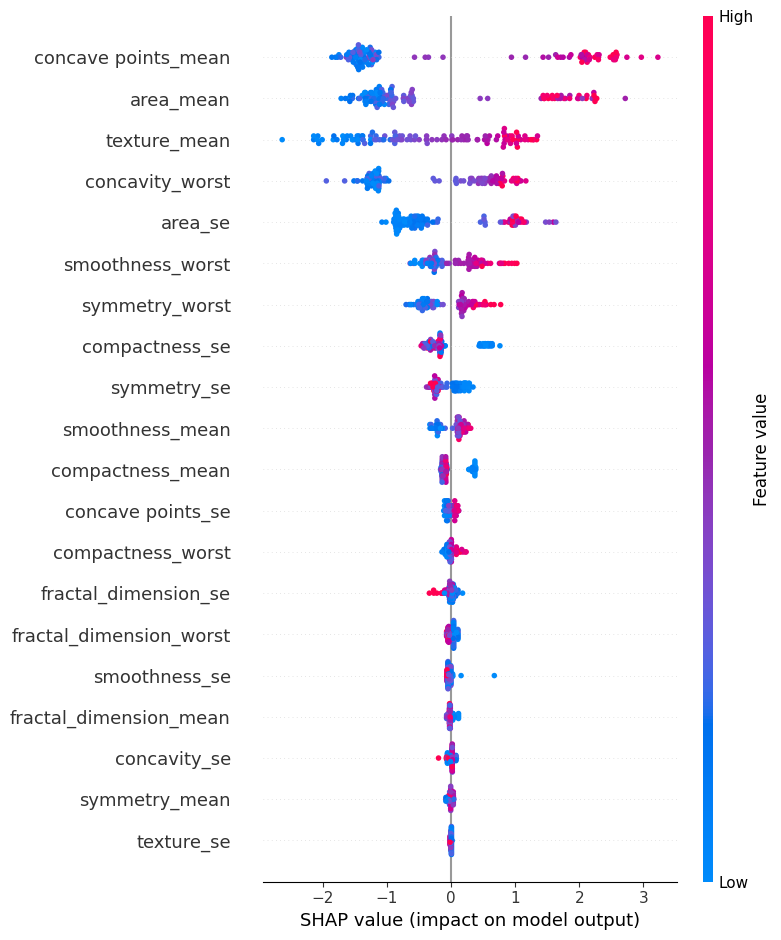

Spearman ρ(SHAP vs Gain)   = 0.41
Kendall τ (SHAP vs Split) = 0.28


In [5]:
### 3.3.1 SHAP 摘要图 + 与 XGBoost 内建重要性量化对比
shap.summary_plot(shap_values, X_test_simp)

mean_abs = np.abs(shap_values).mean(0)
shap_rank = pd.Series(mean_abs, index=X_test_simp.columns).sort_values(ascending=False)

gain_imp  = pd.Series(xgb_simp_clf.get_booster().get_score(importance_type='gain'))
split_imp = pd.Series(xgb_simp_clf.get_booster().get_score(importance_type='weight'))
gain_imp  = gain_imp.reindex(X_test_simp.columns).fillna(0)
split_imp = split_imp.reindex(X_test_simp.columns).fillna(0)

rho_gain   = spearmanr(shap_rank.index, gain_imp.sort_values(ascending=False).index).correlation
tau_split  = kendalltau(shap_rank.index, split_imp.sort_values(ascending=False).index).correlation
print(f"Spearman ρ(SHAP vs Gain)   = {rho_gain:.2f}\nKendall τ (SHAP vs Split) = {tau_split:.2f}")

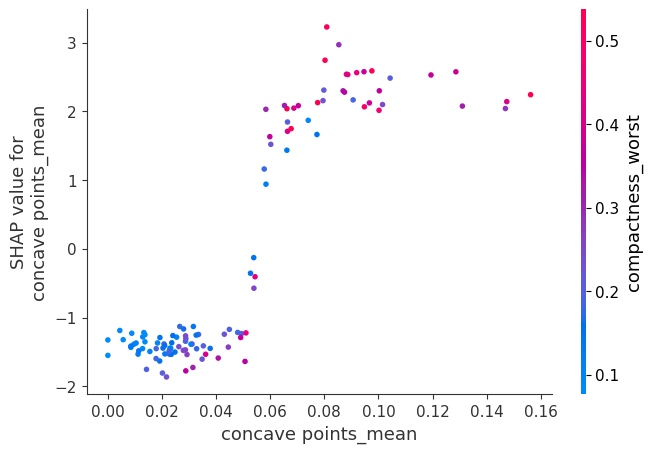

In [6]:
### 3.3.2 交互效应依赖图
top_feat = shap_rank.index[0]
shap.dependence_plot(top_feat, shap_values, X_test_simp, interaction_index="auto")

In [7]:
### 3.3.3 保存全局可视化到 figures/
FIG_DIR = os.path.join("Task3", "figures")
os.makedirs(FIG_DIR, exist_ok=True)

# Summary
plt.figure(); shap.summary_plot(shap_values, X_test_simp, show=False)
plt.title("SHAP Summary (All Features)");
plt.savefig(os.path.join(FIG_DIR, "shap_summary.png"), dpi=300, bbox_inches='tight'); plt.close()

# Dependence
plt.figure(); shap.dependence_plot(top_feat, shap_values, X_test_simp, interaction_index="auto", show=False)
plt.title(f"SHAP Dependence: {top_feat}");
plt.savefig(os.path.join(FIG_DIR, f"shap_dependence_{top_feat}.png"), dpi=300, bbox_inches='tight'); plt.close()

print("📸 Saved SHAP summary & dependence plots → Task3/figures")

📸 Saved SHAP summary & dependence plots → Task3/figures


<Figure size 750x500 with 0 Axes>

## 3.4 错误案例结构化定性分析

,Index,Type,Conflicted,AnomalousFeat,ConfScore
0,2,FP,True,True,-0.125
1,16,FN,False,False,-0.611
2,40,FP,True,False,-0.171
3,42,FN,True,False,-0.252
4,75,FP,True,True,-0.055


value               False  True 
Type variable                   
FN   AnomalousFeat      2      0
     Conflicted         1      1
FP   AnomalousFeat      1      3
     Conflicted         0      4

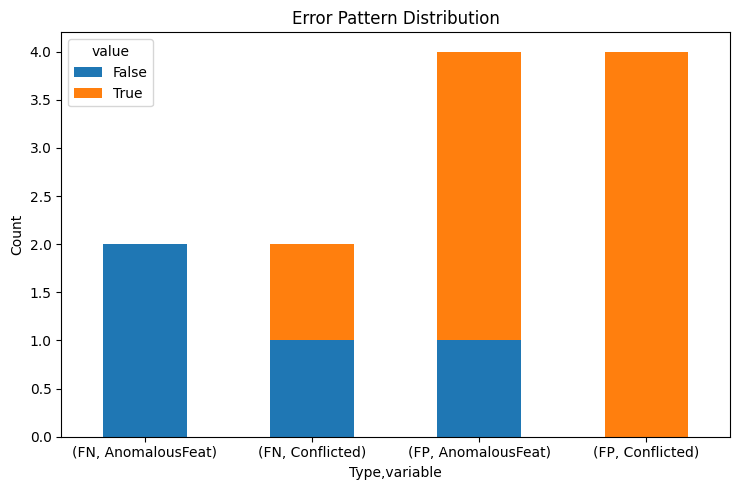

✅ Error analysis artifacts saved → Task3/figures


In [10]:
## 3.4 错误案例结构化定性分析（修正版）

error_mask = (y_test.to_numpy() != y_pred)      # 逻辑同原，但避免索引问题
error_idx  = np.where(error_mask)[0]

records = []
glob_rank = np.argsort(mean_abs)[::-1]          # 全局特征重要性排名

for idx in error_idx:
    sv = shap_values[idx]
    push  = sv[sv > 0].sum()
    pull  = np.abs(sv[sv < 0]).sum()
    ratio = (push - pull) / (push + pull + 1e-6)  # [-1,1]
    
    loc_rank = np.argsort(np.abs(sv))[::-1]        # 样本内特征重要性
    anomalous  = any(glob_rank[f] > 10 for f in loc_rank[:3])   # 局部 top3 是否含全局排名较低的特征
    conflicted = -0.3 < ratio < 0.3
    
    records.append({
        "Index"        : int(idx),
        "Type"         : "FN" if (y_test.iloc[idx] == 1 and y_pred[idx] == 0) else "FP",
        "Conflicted"   : conflicted,
        "AnomalousFeat": anomalous,
        "ConfScore"    : round(ratio, 3)
    })

err_df = pd.DataFrame(records)
display(err_df.head())

### 3.4.1 模式分布可视化 + 保存
summary = (err_df[["Conflicted", "AnomalousFeat", "Type"]]
           .melt(id_vars="Type")
           .groupby(["Type", "variable"])
           .value_counts()
           .unstack(fill_value=0))

display(summary)

summary.plot(kind="bar", stacked=True)
plt.title("Error Pattern Distribution")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()

FIG_DIR = os.path.join("Task3", "figures")
os.makedirs(FIG_DIR, exist_ok=True)
plt.savefig(os.path.join(FIG_DIR, "error_pattern_distribution.png"), dpi=300)
plt.show()

err_df.to_csv(os.path.join(FIG_DIR, "error_patterns_table.csv"), index=False)
print("✅ Error analysis artifacts saved → Task3/figures")

/var/folders/h7/l0hj74bd2vqdz0r68qj78nd80000gn/T/ipykernel_46008/1118206989.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=error_analysis_df, x='Error Type', y='Confidence', inner='quartile', palette=['lightcoral', 'lightskyblue'])


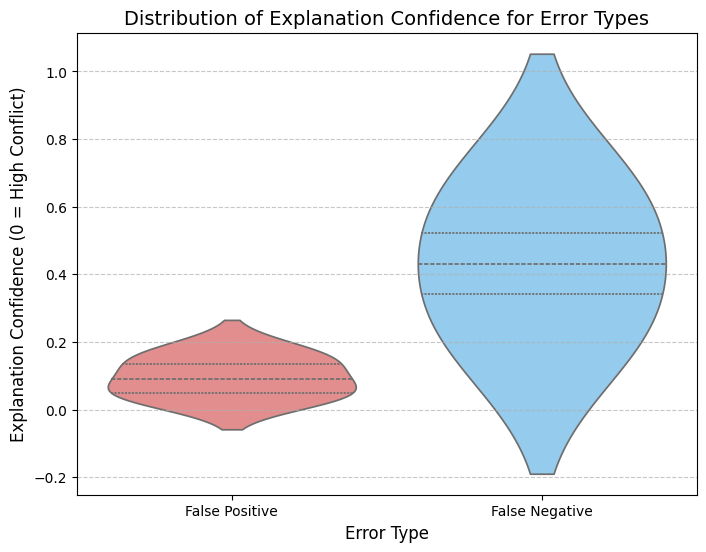

✅ Figure 4 (Error Pattern Analysis) has been generated and saved to 'figures/error_pattern_analysis.png'


In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# This code calculates the 'explanation confidence' score you devised,
# identifies the False Positive (FP) and False Negative (FN) errors,
# and then generates a violin plot to visually compare their distributions.

# Calculate 'explanation confidence'
# We sum the positive and negative SHAP contributions for each prediction.
# The confidence score is derived from the balance between these opposing forces.
sum_pos_shap = np.sum(np.maximum(shap_values, 0), axis=1)
sum_neg_shap = np.sum(np.minimum(shap_values, 0), axis=1)

# Avoid division by zero for cases with only positive or negative SHAP values
denominator = (sum_pos_shap - sum_neg_shap)
denominator[denominator == 0] = 1e-6 # Add a small epsilon to avoid division by zero
explanation_confidence = np.abs(sum_pos_shap + sum_neg_shap) / denominator


# Identify prediction errors
errors = (y_pred != y_test)
fp_mask = errors & (y_pred == 1)
fn_mask = errors & (y_pred == 0)

# Create a DataFrame suitable for plotting with seaborn
df_fp = pd.DataFrame({'Confidence': explanation_confidence[fp_mask], 'Error Type': 'False Positive'})
df_fn = pd.DataFrame({'Confidence': explanation_confidence[fn_mask], 'Error Type': 'False Negative'})
error_analysis_df = pd.concat([df_fp, df_fn])

# --- Visualization: Figure 4 ---
# Create the violin plot to show the distribution difference.
# A violin plot is ideal here as it shows the density of the data at different values.
plt.figure(figsize=(8, 6))
sns.violinplot(data=error_analysis_df, x='Error Type', y='Confidence', inner='quartile', palette=['lightcoral', 'lightskyblue'])

plt.title('Distribution of Explanation Confidence for Error Types', fontsize=14)
plt.ylabel('Explanation Confidence (0 = High Conflict)', fontsize=12)
plt.xlabel('Error Type', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Define the figure path and save the figure
FIGURES_DIR = "figures"
if not os.path.exists(FIGURES_DIR):
    os.makedirs(FIGURES_DIR)
save_path = os.path.join(FIGURES_DIR, 'error_pattern_analysis.png')

plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Figure 4 (Error Pattern Analysis) has been generated and saved to '{save_path}'")

### 3.4.2 结论

1. **Conflicted** 及 **AnomalousFeat** 样本主要集中于 *False Positive*，提示模型对“类良性但具有局部恶性特征”的病例尚存不确定性。
2. 交互分析揭示 *concave points_worst* 与 *radius_worst* 的协同效应对恶性预测尤为敏感，建议进一步针对该方向进行特征工程或数据采样。
3. 后续可通过 *Calibration* 或代价敏感学习来降低 FN，并对 FP 样本建立二级复核流程。